In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from src.metrics import plot_calibration_curve, adaptive_calibration_error

In [2]:
graphics_path = "../images/pdf/"
tables_path = "../tables/"
list_of_all_models = [
    "bert-base-cased", "bert-large-cased", "gemma-2b", "gemma-7b",
    "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "opt-125m",
    "opt-350m", "opt-1.3b", "opt-6.7b", "roberta-base", "roberta-large",
    "xlm-roberta-base", "xlm-roberta-large"
]
instance_lvl_results = pd.read_json(
    "../../scores/BEAR/instance_level_results.json",
    orient="records",
    lines=True
)

## Figure: Calibration Curves verbalized confidence expressions

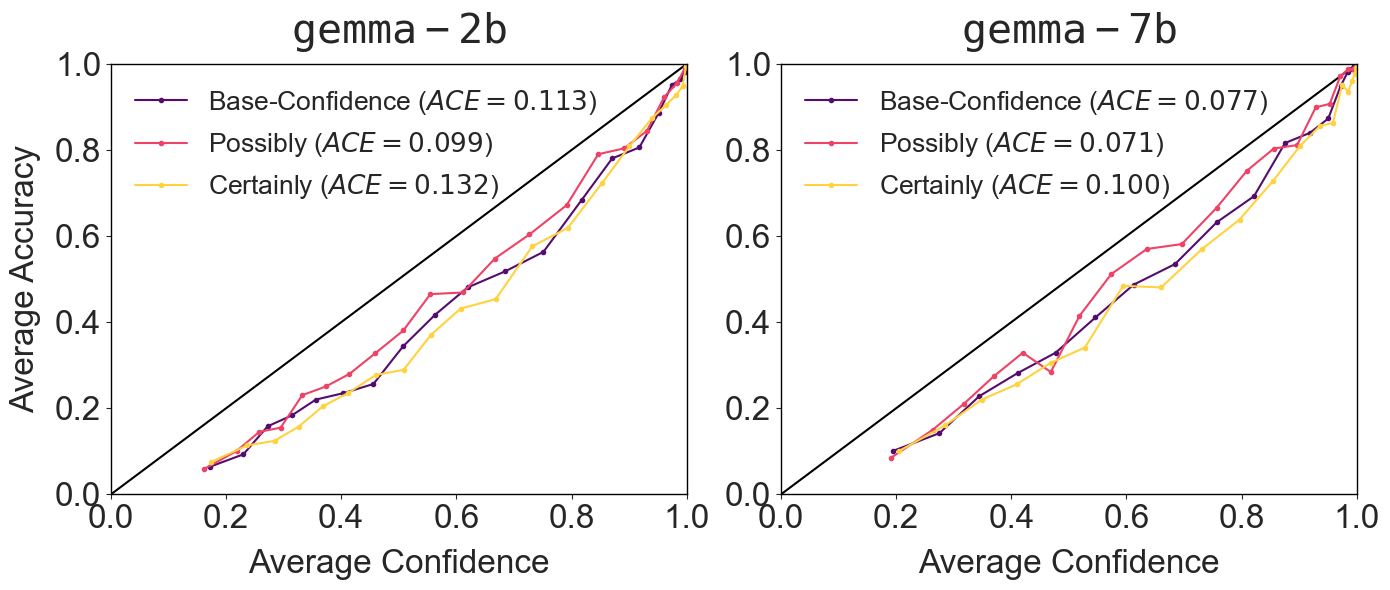

In [3]:
models_info = [
    {
        "title": "gemma-2b",
        "df": instance_lvl_results.query("model == 'gemma-2b'"),
        "pred_keys": ["correctly_predicted", "weakener_correctly_predicted", "strengthener_correctly_predicted"],
        "conf_keys": ["base_conf", "weakener_conf", "strengthener_conf"],
        "ace": [0.113, 0.099, 0.132],
        "labels": ["Base-Confidence", "Possibly", "Certainly"],
        "col": 0
    },
    {
        "title": "gemma-7b",
        "df": instance_lvl_results.query("model == 'gemma-7b'"),
        "pred_keys": ["correctly_predicted", "weakener_correctly_predicted", "strengthener_correctly_predicted"],
        "conf_keys": ["base_conf", "weakener_conf", "strengthener_conf"],
        "ace": [0.077, 0.071, 0.100],
        "labels": ["Base-Confidence", "Possibly", "Certainly"],
        "col": 1
    }
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for info in models_info:
    ax = axes[info["col"]]
    plot_calibration_curve(
        title=rf"$\mathtt{{{info['title']}}}$",
        predictions=[info["df"][k].tolist() for k in info["pred_keys"]],
        confidences=[info["df"][k].tolist() for k in info["conf_keys"]],
        labels=info["labels"],
        linestyles=["solid"]*3,
        markers=["."]*3,
        colors=["#540d6e", "#ee4266", "#ffd23f"],
        title_fontsize=30,
        legend_fontsize=20,
        axes_label_fontsize=24,
        axes_tick_fontsize=24,
        axis=ax,
        n_bins=20,
    )
    if info["col"] > 0:
        ax.set_ylabel("")
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [
        f"{label} ($\\mathit{{ACE={ace:.3f}}}$)"
        for label, ace in zip(labels, info["ace"])
    ]
    ax.legend(handles, new_labels, frameon=False, fontsize=19, loc="upper left")

plt.tight_layout()
plt.savefig(graphics_path + "calibration_curves_forced_epistemicity.pdf", format="pdf")
plt.show()

## Figure: Matrix with difference in ACE (injected vs. non-injected template)

In [4]:
d = {
    "model": [],
    "ace_weakener": [],
    "ace_strengthener": [],
    "ace0": [],
    "ace25": [],
    "ace50": [],
    "ace75": [],
    "ace100": []
}
for m in list_of_all_models:
    temp = instance_lvl_results.query("model == @m")
    ace_base = adaptive_calibration_error(temp.correctly_predicted, temp.base_conf)
    ace_weakener = adaptive_calibration_error(temp.weakener_correctly_predicted, temp.weakener_conf)
    ace_strengthener = adaptive_calibration_error(temp.strengthener_correctly_predicted, temp.strengthener_conf)
    ace0 = adaptive_calibration_error(temp.num_conf_0_correctly_predicted, temp.num_conf_0)
    ace25 = adaptive_calibration_error(temp.num_conf_25_correctly_predicted, temp.num_conf_25)
    ace50 = adaptive_calibration_error(temp.num_conf_50_correctly_predicted, temp.num_conf_50)
    ace75 = adaptive_calibration_error(temp.num_conf_75_correctly_predicted, temp.num_conf_75)
    ace100 = adaptive_calibration_error(temp.num_conf_100_correctly_predicted, temp.num_conf_100)
    d["model"].append(m)
    d["ace_weakener"].append(round(ace_weakener-ace_base, 3))
    d["ace_strengthener"].append(round(ace_strengthener-ace_base, 3))
    d["ace0"].append(round(ace0-ace_base, 3))
    d["ace25"].append(round(ace25-ace_base, 3))
    d["ace50"].append(round(ace50-ace_base, 3))
    d["ace75"].append(round(ace75-ace_base, 3))
    d["ace100"].append(round(ace100-ace_base, 3))

df = pd.DataFrame(d).set_index("model")
df.loc["Average"] = df.mean()   # add the mean

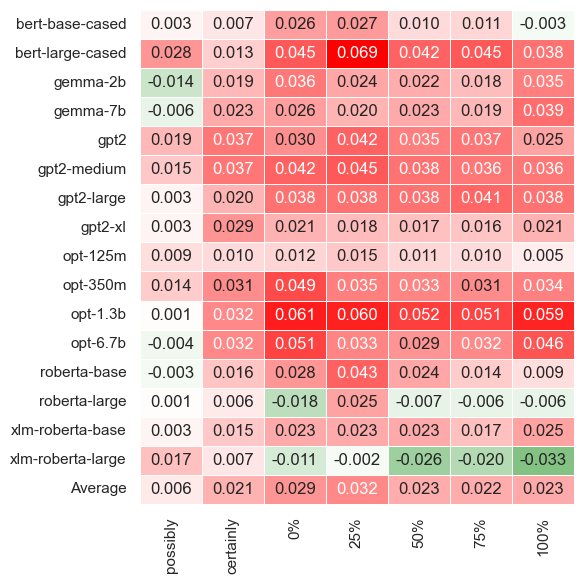

In [5]:
plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")
green_white_red = LinearSegmentedColormap.from_list(
    "green_white_red",
    ["green", "white", "red"]
)

ax = sns.heatmap(
    df,
    cmap=green_white_red,
    center=0,
    annot=True,
    fmt=".3f",
    linewidths=0.6,
    linecolor="white",
    cbar=False
)

ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_xticklabels(["possibly", "certainly", "0%", "25%", "50%", "75%", "100%"], ha="center")
ax.set_ylabel("")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(graphics_path + "ace_matrix_forced_epistemicity.pdf", format="pdf")
plt.show()

## Figure: Matrix with difference in Accuracy (injected vs. non-injected template)

In [6]:
d = {
    "model": [],
    "acc_weakener": [],
    "acc_strengthener": [],
    "acc0": [],
    "acc25": [],
    "acc50": [],
    "acc75": [],
    "acc100": []
}
for m in list_of_all_models:
    temp = instance_lvl_results.query("model == @m")
    acc_base = temp.correctly_predicted.mean()
    acc_weakener = temp.weakener_correctly_predicted.mean()
    acc_strengthener = temp.strengthener_correctly_predicted.mean()
    acc0 = temp.num_conf_0_correctly_predicted.mean()
    acc25 = temp.num_conf_25_correctly_predicted.mean()
    acc50 = temp.num_conf_50_correctly_predicted.mean()
    acc75 = temp.num_conf_75_correctly_predicted.mean()
    acc100 = temp.num_conf_100_correctly_predicted.mean()
    d["model"].append(m)
    d["acc_weakener"].append(round(acc_weakener-acc_base, 3))
    d["acc_strengthener"].append(round(acc_strengthener-acc_base, 3))
    d["acc0"].append(round(acc0-acc_base, 3))
    d["acc25"].append(round(acc25-acc_base, 3))
    d["acc50"].append(round(acc50-acc_base, 3))
    d["acc75"].append(round(acc75-acc_base, 3))
    d["acc100"].append(round(acc100-acc_base, 3))
df = pd.DataFrame(d).set_index("model")
df.loc["Average"] = df.mean()

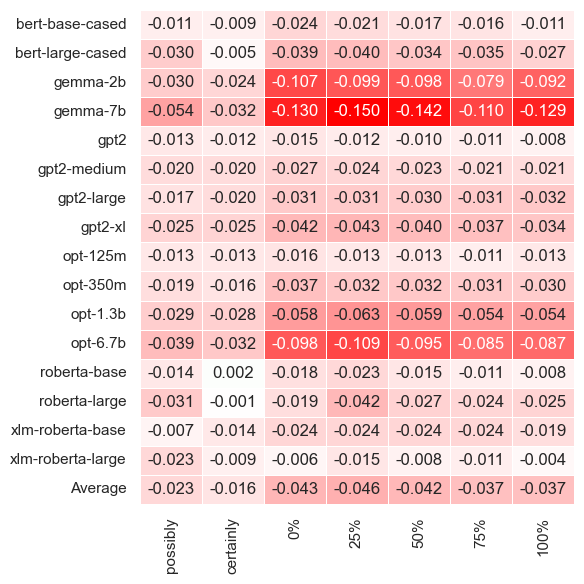

In [7]:
plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")
red_white_green = LinearSegmentedColormap.from_list(
    "red_white_green",
    ["red", "white", "green"]
)

ax = sns.heatmap(
    df,
    cmap=red_white_green,
    center=0,
    annot=True,
    fmt=".3f",
    linewidths=0.6,
    linecolor="white",
    cbar=False
)

ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_xticklabels(["possibly", "certainly", "0%", "25%", "50%", "75%", "100%"], ha="center")
ax.set_ylabel("")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(graphics_path + "accuracy_matrix_forced_epistemicity.pdf", format="pdf")
plt.show()